<a href="https://colab.research.google.com/github/C242-PS091-Capstone-Bangkit/ML-Project/blob/main/SkinType/Skin_Type_Model_InceptionV3_With_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1: Using CNN's with the Skin Type Dataset

For the first model we will use the `skin type` dataset to train a model that can classify 3 skin types. For this, we will create own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities. In addition, we also tried the pre-trained model from InceptionV3.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install Required Libraries

Before we proceed with dataset, let's first install the required libraries to ensure everything is set up correctly for the next steps.

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import ipywidgets as widgets
from io import BytesIO
from PIL import Image
from google.colab import files

Since we have already installed the required libraries, we can now proceed to the next step, which is **Pre-Processing the Dataset**.

<a name="2"></a>
## Pre-Processing the Dataset

Let's explore the dataset in the folder `./SkinType`. There is a subdirectory for each class. The complete tree looks like this:

```
.
└── SkinType/
    ├── Normal/
    │   ├── normal_1.jpg
    │   ├── normal_2.jpg
    │   └── ...
    └── Dry/
        ├── dry_1.jpg
        ├── dry_2.jpg
    |   └── ...
    └── Oily/
        ├── oily_1.jpg
        ├── oily_2.jpg
        └── ...

```

### Load Image

Before we begin building the model, let's load an image to explore it's content and understand it's properties. This will help us get a clearer idea of the data we're working with and ensure that we can process the images correctly for the next steps.

In [ ]:
DATA_DIR = '/content/drive/My Drive/Skin Type/Clean Data'

data_dir_normal = os.path.join(DATA_DIR, 'Normal')
data_dir_dry = os.path.join(DATA_DIR, 'Dry')
data_dir_oily = os.path.join(DATA_DIR, 'Oily')

print(f"There are {len(os.listdir(data_dir_normal))} images of normal skin type.")
print(f"There are {len(os.listdir(data_dir_dry))} images of dry skin type.")
print(f"There are {len(os.listdir(data_dir_oily))} images of oily skin type.")

There are 1080 images of normal skin type.
There are 946 images of dry skin type.
There are 1098 images of oily skin type.


While it's useful to know the number of images in each class, let's visualize a few of them to gain a clearer understanding of the types of images in the dataset:

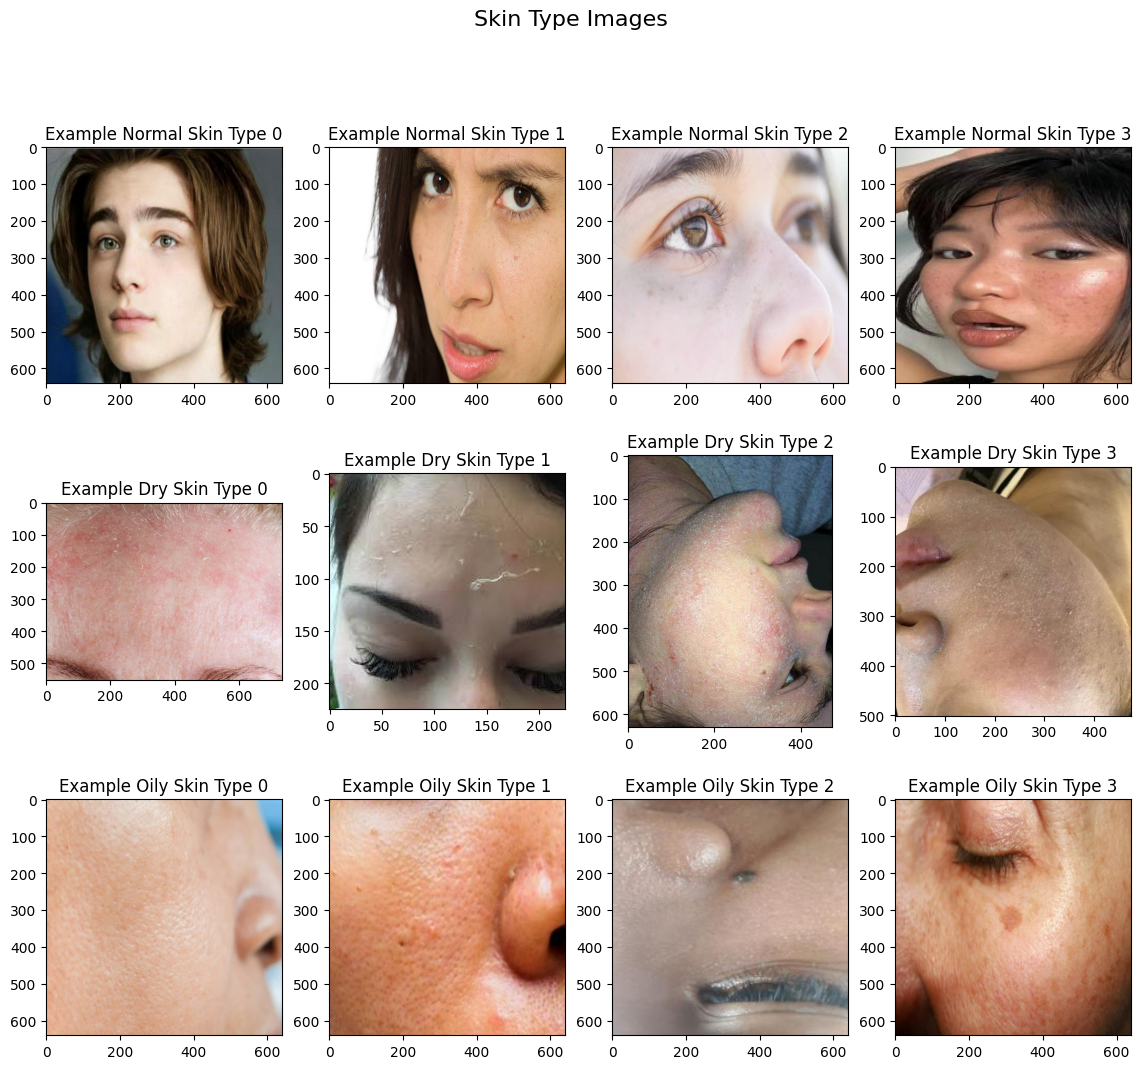

In [ ]:
normal_filenames = [os.path.join(data_dir_normal, filename) for filename in os.listdir(data_dir_normal)]
dry_filenames = [os.path.join(data_dir_dry, filename) for filename in os.listdir(data_dir_dry)]
oily_filenames = [os.path.join(data_dir_oily, filename) for filename in os.listdir(data_dir_oily)]

num_examples = 4

random_normal = random.sample(normal_filenames, num_examples)
random_dry = random.sample(dry_filenames, num_examples)
random_oily = random.sample(oily_filenames, num_examples)

fig, axes = plt.subplots(3, num_examples, figsize=(14, 12))
fig.suptitle('Skin Type Images', fontsize=16)

for i, normal_image in enumerate(random_normal):
    img = tf.keras.utils.load_img(normal_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Normal Skin Type {i}')

for i, dry_image in enumerate(random_dry):
    img = tf.keras.utils.load_img(dry_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dry Skin Type {i}')

for i, oily_image in enumerate(random_oily):
    img = tf.keras.utils.load_img(oily_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Oily Skin Type {i}')

plt.show()

These example images from each skin condition class are certainly interesting! Notice that these images come in all kinds of resolutions!

### Split Dataset

Once we have loaded the images, the next step is to split the dataset into training and validation sets. This split ensures that we can train our model on one portion of the data while using another portion to evaluate its performance.

In [ ]:
def train_val_datasets():
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='training',
        seed=42
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(224, 224),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='validation',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
training_dataset, validation_dataset = train_val_datasets()

Found 3124 files belonging to 3 classes.
Using 2500 files for training.
Found 3124 files belonging to 3 classes.
Using 624 files for validation.


At this point, we now have two separate datasets, one dedicated to training the model and the other for validating its performance.

The training dataset will be used to teach the model to recognize patterns and make predictions, while the validation dataset will allow we to assess how well the model generalizes to new, unseen data, helping to fine-tune the model and avoid overfitting.

In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 224, 224, 3)
Shape of batch of labels: (128, 3)


Keep in mind that the pixel values of the images are not normalized yet, so we need to add a Rescaling layer in the model to scale these values by a factor of 1./255.

## Data Augmentation

With the data in the approciate format, the next step is to apply data augmentation to enhance the model's robustness by creating varied image versions through transformations such as rotation, flipping, scaling, or color adjustments.

In [ ]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
    ])
    return augmentation_model

augmentation_model = create_augmentation_model()
train_dataset = training_dataset.map(lambda x, y: (augmentation_model(x), y))

In [ ]:
def demo_augmentation(sample_image, model, num_aug):

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

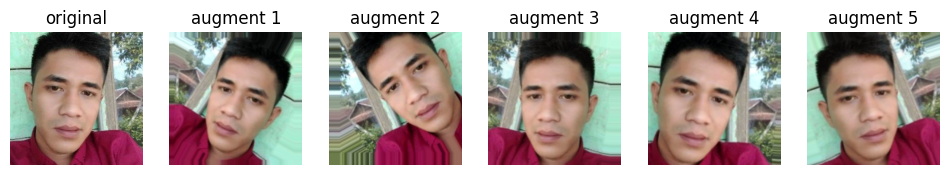

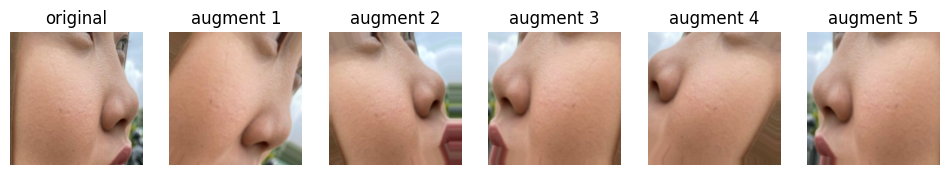

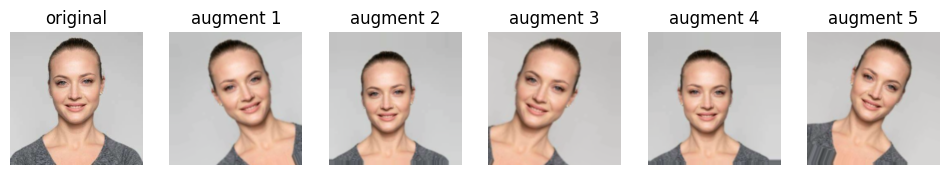

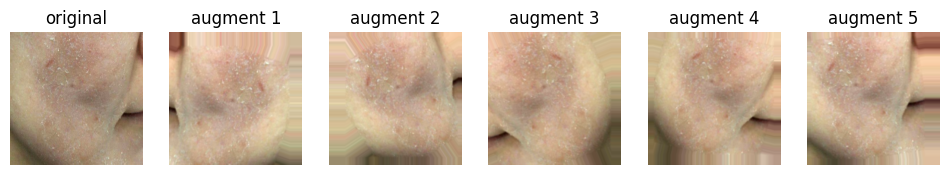

In [ ]:
NUM_AUG = 5

sample_batch = list(training_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[1], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[2], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[3], create_augmentation_model(), NUM_AUG)

del sample_batch

Now that we have applied data augmentation, the datasets with varied image versions are ready, and we can proceed to the next step, which is **Build and Train The Model**.

##Build and Train The Model

After completing the pre-processing steps, we will proceed by building the model using pre-trained model from InceptionV3 and perform fine-tuning starting from layer 150 to adapt the model to our specific dataset.

In [ ]:
import tensorflow as tf

def create_transfer_learning_model():

    base_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(
        128, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    fine_tune_at = 150
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

The next cell allows us to examine the total number of parameters in the model.

In [ ]:
model = create_transfer_learning_model()
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,443 (84.17 MB)

 Trainable params: 17,629,635 (67.25 MB)

 Non-trainable params: 4,435,808 (16.92 MB)

Now, we can begin training the model. We will use 100 epochs for the training process.

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 827s 37s/step - accuracy: 0.4873 - loss: 3.4793 - val_accuracy: 0.7541 - val_loss: 2.9961
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8281 - loss: 2.7855 - val_accuracy: 0.8689 - val_loss: 2.6731
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9161 - loss: 2.4952 - val_accuracy: 0.8951 - val_loss: 2.5323
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.9468 - loss: 2.3323 - val_accuracy: 0.9131 - val_loss: 2.4032
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9661 - loss: 2.2123 - val_accuracy: 0.9377 - val_loss: 2.2731
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9712 - loss: 2.1162 - val_accuracy: 0.9230 - val_loss: 2.1991
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9709 - loss: 2.0270 - val_accuracy: 0.9459 - val_loss: 2.0736
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9714 - loss: 1.9419 - val_accuracy: 0.9361 -

The following code will display the training and validation accuracy achieved at the end of each epoch once the training is complete.

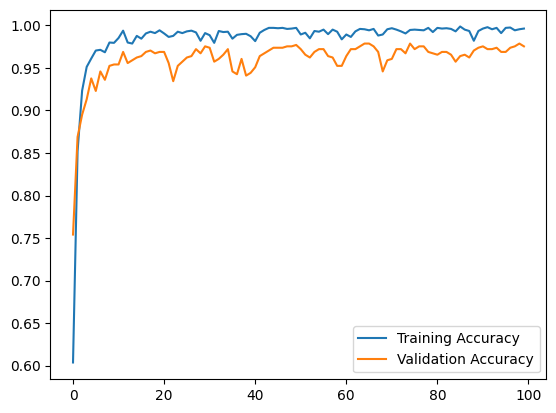

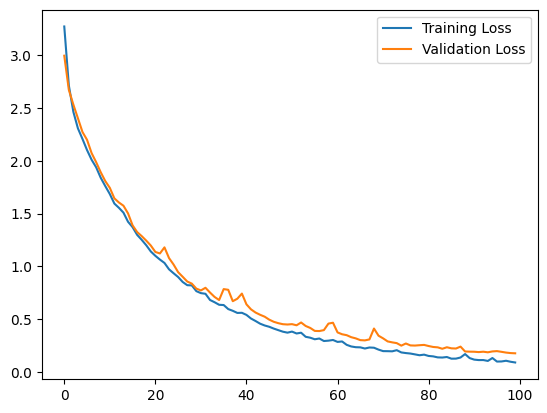

In [ ]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Now that we have successfully built and trained the model using the prepared dataset to achieve high accuracy, we can proceed to the next step, which is **Evaluate the Model**.

## Evaluate the Model

After training the model, we evaluate its performance using the confusion matrix. We can also view the Classification Report, which includes precision, recall, f1-score, and support for each class.

But, before creating the confusion matrix, we need to ensure that the labels are correctly assigned and match the predicted values with the actual ones.

In [ ]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(DATA_DIR, transform=transforms.ToTensor())
print(dataset.class_to_idx)

{'Dry': 0, 'Normal': 1, 'Oily': 2}


After ensuring the labels are correctly assigned, we can run the following code to evaluate the model using the confusion matrix.

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step


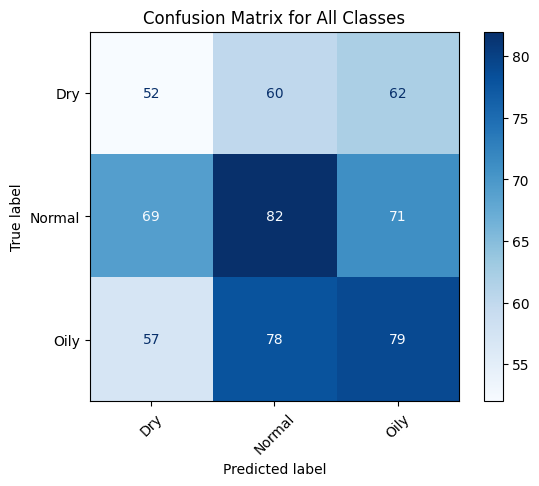

Classification Report:
              precision    recall  f1-score   support

         Dry       0.29      0.30      0.30       174
      Normal       0.37      0.37      0.37       222
        Oily       0.37      0.37      0.37       214

    accuracy                           0.35       610
   macro avg       0.35      0.35      0.35       610
weighted avg       0.35      0.35      0.35       610



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_true, axis=1)

cm = confusion_matrix(y_true_class, y_pred_class)

class_labels = ['Dry', 'Normal', 'Oily']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Confusion Matrix for All Classes")
plt.show()

print("Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=class_labels))

The evaluation results show that the confusion matrix values are not very high, due to **various influencing factors**.

However, despite the confusion matrix not being very high, the model can still be tested in the next step to prove its **real-world performance on unseen data**. We will move on to the next step, which is **Test the Model**.

## Test the Model


After successfully building the model and evaluating it with a confusion matrix, we can proceed to test the model using previously unseen data to measure its performance and generalization.

Upload an image after running the following code and observe the classification results with confidence values.

Saving Screenshot 2024-12-08 174624.png to Screenshot 2024-12-08 174624.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


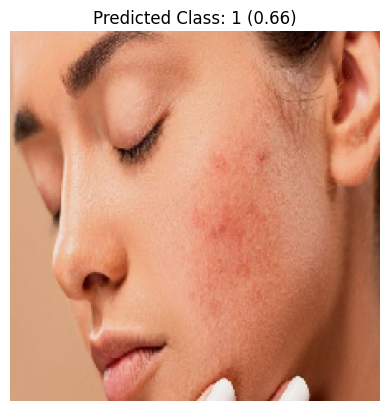

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving Screenshot 2024-12-08 174602.png to Screenshot 2024-12-08 174602.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


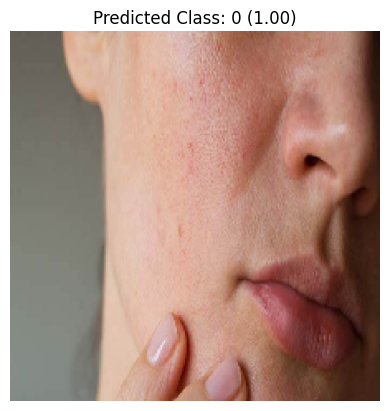

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving Screenshot 2024-12-08 163101.png to Screenshot 2024-12-08 163101 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


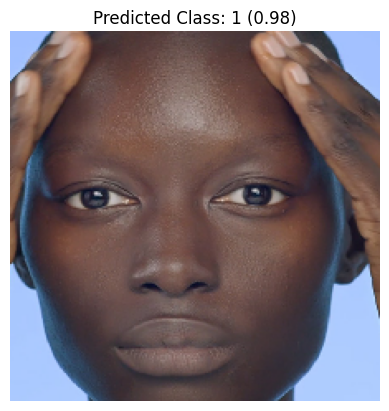

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving minyak.jpg to minyak (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


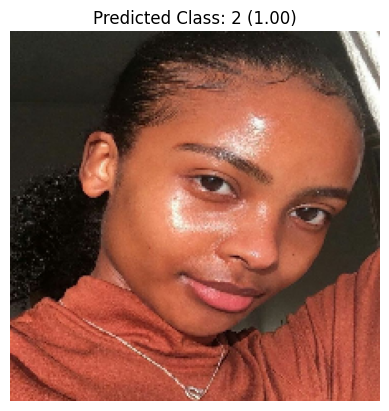

Apakah Anda ingin memprediksi gambar lain? (y/n): y


Saving kering (100).jpeg to kering (100) (2).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


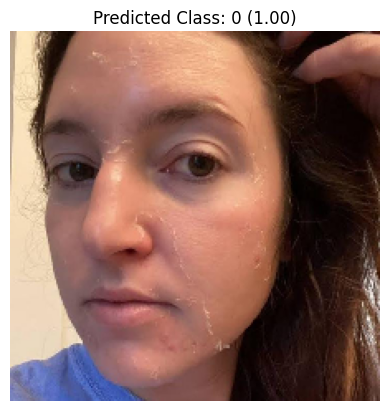

Apakah Anda ingin memprediksi gambar lain? (y/n): n


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict():
    while True:
        uploaded = files.upload()

        for filename in uploaded.keys():
            img_path = filename
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)

            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)
            confidence = predictions[0][predicted_class[0]]

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted Class: {predicted_class[0]} ({confidence:.2f})")
            plt.show()

        more_images = input("Apakah Anda ingin memprediksi gambar lain? (y/n): ")
        if more_images.lower() != 'y':
            break

upload_and_predict()

Saving aug_Berminyak62_jpg.rf.c30809ebf00f6485427795b09b148409.jpg to aug_Berminyak62_jpg.rf.c30809ebf00f6485427795b09b148409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


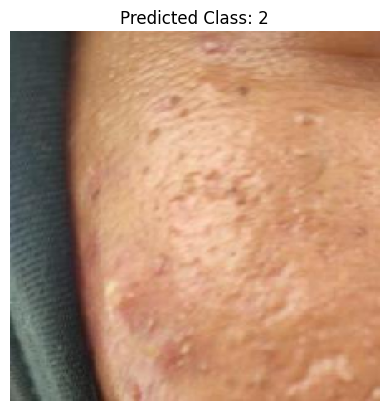

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict():
    uploaded = files.upload()

    for filename in uploaded.keys():
        img_path = filename
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class[0]}")
        plt.show()

upload_and_predict()

Saving OIP - 2024-11-20T165938.386.jpeg to OIP - 2024-11-20T165938.386 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


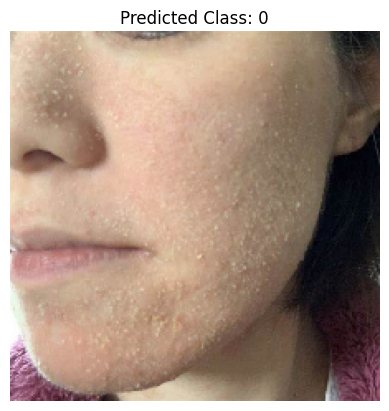

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict():
    uploaded = files.upload()

    for filename in uploaded.keys():
        img_path = filename
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class[0]}")
        plt.show()

upload_and_predict()

Saving test.jpg to test.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


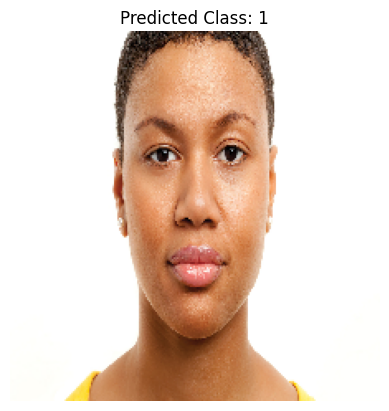

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict():
    uploaded = files.upload()

    for filename in uploaded.keys():
        img_path = filename
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted Class: {predicted_class[0]}")
        plt.show()

upload_and_predict()

As seen in the classification results above, although the confusion matrix values are **not very high**, the classes are **correctly predicted**, and the model has a **satisfactory confidence level**. This proves that the model is able to classify the skin type reasonably well, and further improvements can be made through fine-tuning.

Once the tests for each class are completed, we can now save the model by running the following code:

In [ ]:
model.save('skin_type_model1.h5')
files.download('skin_type_model1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally! We have completed all the steps and successfully built a model for skin type classification, saved in h5 format!